# Acetycholine modulates plasticity at CA3 pyramidal cell synapses by suppressing feedforward inhibition driven by mossy fibre input

In [1]:
%matplotlib inline

import numpy as np
from neuron import h,gui
import matplotlib.pyplot as plt

### Load cell topology and set parameters 

In [2]:
h.cvode_active(1)

Vrest = -64
h.dt = 0.05
h.celsius = 35.0
freq = 20

'''Cell Topology'''
numaxon=1
numsoma=1
numbasal=52
numapical=81

h.xopen('./fig5_data/geo-cell1zr.hoc') # from Hemond et al (2008)
h.xopen('./fig5_data/fixnseg.hoc')

'''Passive parameters'''
Rm = 25370
Cm = 1.41
RaAll = 150

'''Active parameters'''
AXONM = 5
gna = 0.022
KMULT = 0.02
gc = 1e-05
gcal = gc
gcan = gc
gcat = gc
ghd = 0.00001

'''Vary K-channel conductances to obtain different spiking regimes (Hemond et al, 2008)'''
'''Currently set with bursty parameters'''
gkdr = 0.005
gkm = 0.017
gkd = 0.00
gKc = 5e-5
gahp = 0.0001

h.tstop = 500

In [3]:
''' Show morphology in neuron gui'''

shape_window = h.PlotShape()
shape_window.exec_menu('Show Diam')

0.0

### Set cell biophysics 

In [4]:
''' Insert channels and set channel conductances'''
for sec in h.allsec():
    sec.insert('na3')
    sec.insert('kdr')
    sec.insert('kap')
    sec.insert('pas')
    
    if 'axon' not in sec.name():
        sec.insert('ds')
        sec.insert('hd')
        sec.insert('cacum')
        sec.insert('cal')
        sec.insert('can')
        sec.insert('cat')
        sec.insert('cagk')
        sec.insert('KahpM95')
        
        sec.depth_cacum = sec.diam/2.
        
        if 'soma' in sec.name():
            sec.insert('kd')
            sec.insert('km')
            
    sec.v=Vrest
    sec.e_pas=Vrest
    sec.g_pas = 1./Rm
    sec.Ra = RaAll
    sec.cm = Cm
    sec.ek = -90
    sec.ena = 55
    h.ehd_hd = -30
    
    if h.ismembrane('cal',sec=sec):
        sec.gcalbar_cal=gc
        sec.gcanbar_can=gc
        sec.gcatbar_cat=gc
        sec.gbar_cagk = gKc
        sec.gbar_KahpM95 = gahp
        
    if 'axon' in sec.name():
        sec.gbar_na3=gna*AXONM
        sec.gkdrbar_kdr=gkdr
        sec.gkabar_kap = KMULT
        sec.sh_kap = 0
        sec.Ra = RaAll/3.
        
    if 'soma' in sec.name():
        sec.ghdbar_hd=ghd
        sec.gbar_na3=gna
        sec.gkdrbar_kdr=gkdr
        sec.gkabar_kap = KMULT
        sec.gbar_km = gkm
        sec.gkdbar_kd = gkd
        
    if 'dendrite' in sec.name():
        sec.ghdbar_hd = ghd
        sec.gbar_na3 = gna
        sec.gkdrbar_kdr = gkdr
        sec.gkabar_kap = KMULT

In [5]:
''' Script that readjusts some parameters according to distance that I didn't know how to convert to python'''

h.xopen('./fig5_data/reinit.hoc')

	1 
	1 
	1 
	0 


1.0

### Show cell response to somatic current injection

In [6]:
'''Stimulation to reproduce Figure 9 from Hemond et al (2009)'''

stim = h.IClamp(0.5,sec=h.soma[0])
stim.dur = 400
stim.delay = 50
stim.amp = 1.5

t_vec = h.Vector()
v_vec = h.Vector()

t_vec.record(h._ref_t)
v_vec.record(h.soma[0](0.5)._ref_v)

h.run()

0.0

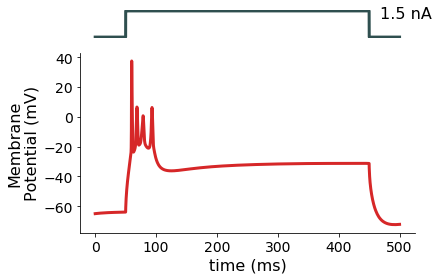

In [7]:
fig = plt.figure(figsize=(6,4))

plt.plot(t_vec,v_vec,color='C3',lw=3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (ms)',fontsize=16)
plt.ylabel('Membrane\nPotential (mV)',fontsize=16)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax = fig.add_axes([0.125,0.8,0.775,0.1])
plt.plot(t_vec,(np.array(t_vec)>50)*(np.array(t_vec)<=450),color='darkslategrey',lw=3)
ax.axis('off')

fig.subplots_adjust(top=0.75)
fig.text(x=0.82,y=0.87,s='1.5 nA',fontsize=16)

fig.savefig('./reworked_figs/ca3pc-firing.svg')

### Split up dendritic compartments into sublayers according to distance

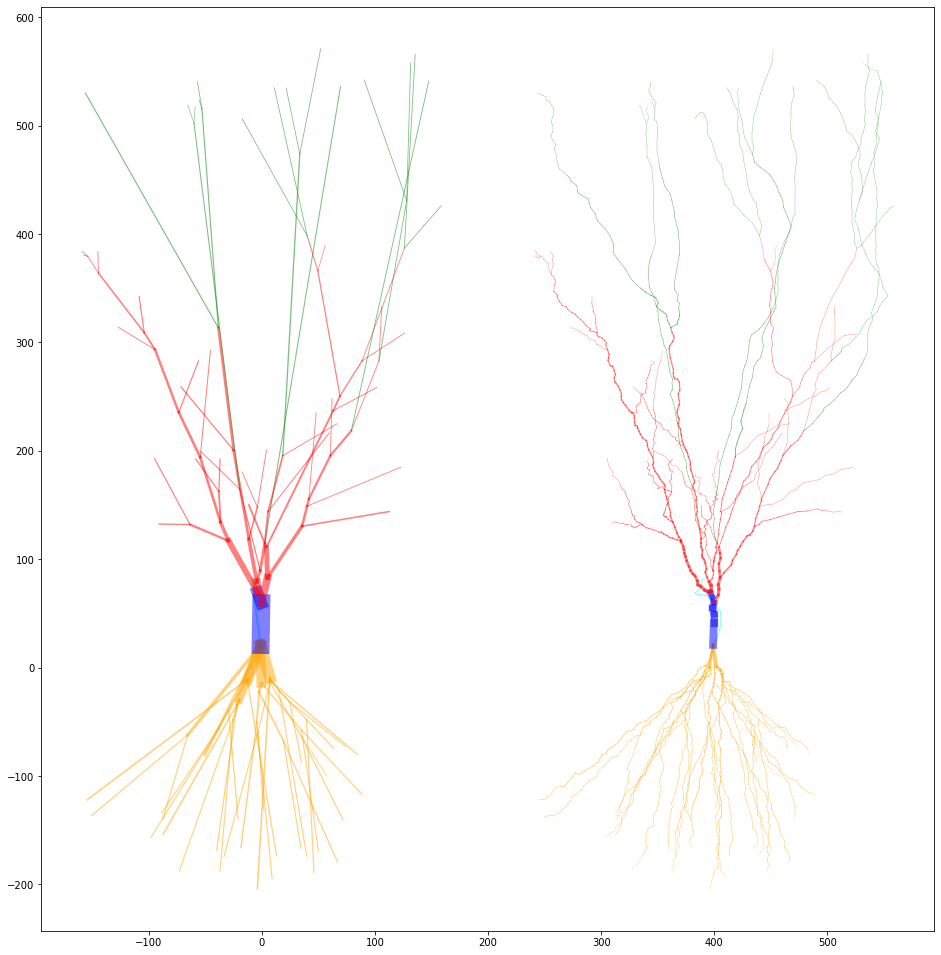

In [8]:
plt.figure(figsize=(16,17))

sl_dendrites = []
sr_dendrites = []
slm_dendrites = []

for sec in h.allsec():
    h.define_shape()
    x1,x2 = h.x3d(0),h.x3d(h.n3d()-1)
    y1,y2 = h.y3d(0),h.y3d(h.n3d()-1)
    w = sec.diam
    if sec in list(h.soma):
        color = 'cyan'
    if sec in list(h.dendrite):
        color = 'orange'
    if sec in h.apical_dendrite:
        if y1<75 and y2<75:
            color = 'blue'
            sl_dendrites.append(sec)
        elif y1<400 and y2<400:
            color = 'red'
            sr_dendrites.append(sec)
        else:
            color = 'green'
            slm_dendrites.append(sec)
            
    plt.plot([x1,x2],[y1,y2],'-',lw=w*2,color=color,alpha=0.5)
    
    for i in range(int(h.n3d()))[1:]:
        x1,x2 = h.x3d(i-1),h.x3d(i)
        y1,y2 = h.y3d(i-1),h.y3d(i)
        w = h.diam3d(i)
        
        if sec in list(h.soma):
            color = 'cyan'
        if sec in list(h.dendrite):
            color = 'orange'
        if sec in sl_dendrites:
            color = 'blue'
        if sec in sr_dendrites:
            color = 'red'
        if sec in slm_dendrites:
            color = 'green'
        
        plt.plot([x1+400,x2+400],[y1,y2],'-',lw=w,color=color,alpha=0.5)

##  Mossy fibre input

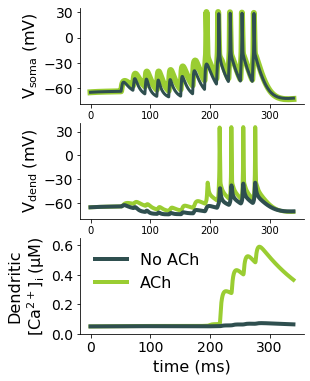

In [28]:
'''Spike train '''

stim = h.NetStim()
stim.interval = 20
stim.number = 12
stim.start = 50

'''Excitatory synaptic input'''

esyn = h.fac_exp2syn(sl_dendrites[0](0.5)) # mossy fibre input to stratum lucidum dendrite
esyn.e=10
esyn.tau1=0.7
esyn.tau2=7

encstim = h.NetCon(stim,esyn)
encstim.weight[0]=0.15

'''Inhibitory synaptic input'''

i=0
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(4,6),sharex=True,sharey='row',frameon=False)

colors = ['darkslategray','yellowgreen']

ach_result = []

for ach_imult in [3.0,1.0]: # For full and decrease feedforward inhibition
    isyns = []
    inclist = []
    for sec in [h.soma[0]]+sl_dendrites+sr_dendrites: # split up feedforward inhibition amongst various comparments

        isyn = h.afacdep_exp2syn(sec(0.5))
        isyn.e = -75
        isyn.tau1 = 4
        isyn.tau2 = 24

        isyns.append(isyn)

        incstim = h.NetCon(stim,isyn)
        incstim.delay=3
        if 'soma' in sec.name():
            incstim.weight[0] = encstim.weight[0]*ach_imult/2
        if 'dendrite' in sec.name():
            incstim.weight[0] = encstim.weight[0]*ach_imult/(2*len(sl_dendrites+sr_dendrites))
            
        inclist.append(incstim)
    
    
    '''Record'''
    vs_vec = h.Vector()
    vd_vec = h.Vector()
    ca_vec = h.Vector()
    t_vec = h.Vector()

    vs_vec.record(h.soma[0](0.5)._ref_v)
    vd_vec.record(sr_dendrites[-12](0.5)._ref_v) # record from stratrum radiatum dendrite where rec. syns located
    ca_vec.record(sr_dendrites[-12](0.5)._ref_cai)
    t_vec.record(h._ref_t)
    
    h.tstop = stim.start*2 + stim.number*stim.interval
    h.run()
    
    ach_result.append([np.array(t_vec), np.array(vs_vec), np.array(vd_vec), np.array(ca_vec)])
    
    plt.sca(axs[0])
    plt.plot(t_vec,vs_vec,lw=3+3*i,color=colors[i],zorder=2-i)
    
    plt.sca(axs[1])
    plt.plot(t_vec,vd_vec,lw=4,color=colors[i],zorder=2-i)
    
    plt.sca(axs[2])
    plt.plot(t_vec,np.array(ca_vec)*1000,lw=4,color=colors[i],zorder=2-i)
    
    i+=1
    
fig.subplots_adjust(wspace=0.1)

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
plt.sca(axs[0])
plt.ylabel('$\mathrm{V_{soma}}$ (mV)',fontsize=16)
plt.yticks([-60,-30,0,30],fontsize=14)

plt.sca(axs[1])
plt.ylabel('$\mathrm{V_{dend}}$ (mV)',fontsize=16)
plt.yticks([-60,-30,0,30],fontsize=14)

plt.sca(axs[2])
plt.ylabel('Dendritic\n$\mathrm{[Ca^{2+}]_i\:(\mu M)}$',fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel('time (ms)',fontsize=16)
plt.xticks(fontsize=14)
plt.ylim(0, 0.65)

plt.legend(['No ACh','ACh'],fontsize=16,frameon=False)

fig.savefig('./reworked_figs/ca3_backprop_ach_example.svg')

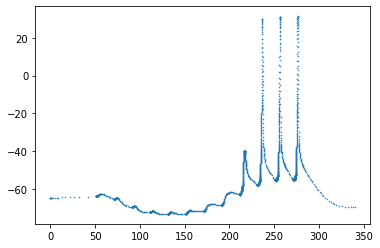

In [17]:
plt.plot(t_vec, vd_vec, '.', ms=1)

In [18]:
def find_vpeaks(v):
    dv = np.diff(v)
    pks = np.where((dv>0)[:-1]*(dv<0)[1:])[0] + 1
    return pks

def find_nearest_peak(va_pks,vb,win=150):
    vb_pks = [np.max(vb[pk:pk+win]) for pk in va_pks]
    return np.array(vb_pks)

def average_vdenpeaks(vsom,vden):
    vsom_pks = find_vpeaks(vsom)
    vden_pks = find_nearest_peak(vsom_pks,vden)
    vden_pks_av = np.mean(vden_pks[vsom[vsom_pks]>0])
    return vden_pks_av

def caInfluxPerSpike(num_spikes,ca,t):
    int1 = np.sum(ca[1:]*np.diff(t))
    int2 = np.sum(ca[:-1]*np.diff(t))
    cai_per_spike = np.mean([int1,int2])/num_spikes
    return cai_per_spike

In [19]:
average_vdenpeaks(vs_vec, vd_vec)

TypeError: sequence index must be integer, not 'slice'

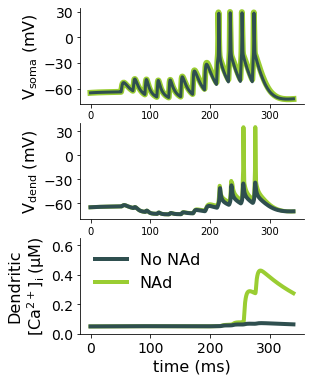

In [32]:
'''Spike train '''

stim = h.NetStim()
stim.interval = 20
stim.number = 12
stim.start = 50

'''Excitatory synaptic input'''

esyn = h.fac_exp2syn(sl_dendrites[0](0.5)) # mossy fibre input to stratum lucidum dendrite
esyn.e=10
esyn.tau1=0.7
esyn.tau2=7

encstim = h.NetCon(stim,esyn)
encstim.weight[0]=0.15

'''Inhibitory synaptic input'''

i=0
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(4,6),sharex=True,sharey='row',frameon=False)

colors = ['darkslategray','yellowgreen']

nad_result = []

for nad_imult in [1.0, 2.0]: # For full and decrease feedforward inhibition
    isyns = []
    inclist = []
    for sec in [h.soma[0]]+sl_dendrites+sr_dendrites: # split up feedforward inhibition amongst various comparments

        isyn = h.afacdep_exp2syn(sec(0.5))
        isyn.e = -75
        isyn.tau1 = 4
        isyn.tau2 = 24
        isyn.taud = 800 * nad_imult

        isyns.append(isyn)

        incstim = h.NetCon(stim,isyn)
        incstim.delay=3
        if 'soma' in sec.name():
            incstim.weight[0] = encstim.weight[0]*3.0/2
        if 'dendrite' in sec.name():
            incstim.weight[0] = encstim.weight[0]*3.0/(2*len(sl_dendrites+sr_dendrites))
            
        inclist.append(incstim)
    
    
    '''Record'''
    vs_vec = h.Vector()
    vd_vec = h.Vector()
    ca_vec = h.Vector()
    t_vec = h.Vector()

    vs_vec.record(h.soma[0](0.5)._ref_v)
    vd_vec.record(sr_dendrites[-12](0.5)._ref_v) # record from stratrum radiatum dendrite where rec. syns located
    ca_vec.record(sr_dendrites[-12](0.5)._ref_cai)
    t_vec.record(h._ref_t)
    
    h.tstop = stim.start*2 + stim.number*stim.interval
    h.run()
    
    nad_result.append([np.array(t_vec), np.array(vs_vec), np.array(vd_vec), np.array(ca_vec)])
    
    plt.sca(axs[0])
    plt.plot(t_vec,vs_vec,lw=3+3*i,color=colors[i],zorder=2-i)
    
    plt.sca(axs[1])
    plt.plot(t_vec,vd_vec,lw=4,color=colors[i],zorder=2-i)
    
    plt.sca(axs[2])
    plt.plot(t_vec,np.array(ca_vec)*1000,lw=4,color=colors[i],zorder=2-i)
    
    i+=1
    
fig.subplots_adjust(wspace=0.1)

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
plt.sca(axs[0])
plt.ylabel('$\mathrm{V_{soma}}$ (mV)',fontsize=16)
plt.yticks([-60,-30,0,30],fontsize=14)

plt.sca(axs[1])
plt.ylabel('$\mathrm{V_{dend}}$ (mV)',fontsize=16)
plt.yticks([-60,-30,0,30],fontsize=14)

plt.sca(axs[2])
plt.ylabel('Dendritic\n$\mathrm{[Ca^{2+}]_i\:(\mu M)}$',fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel('time (ms)',fontsize=16)
plt.xticks(fontsize=14)
plt.ylim(0, 0.65)

plt.legend(['No NAd','NAd'],fontsize=16,frameon=False)

fig.savefig('./reworked_figs/ca3_backprop_nad_example.svg')

## Record bAP amplitude for all dendritic locations in radiatum

In [101]:
def find_vpeaks(v):
    dv = np.diff(v)
    pks = np.where((dv>0)[:-1]*(dv<0)[1:])[0] + 1
    return pks

def find_nearest_peak(va_pks,vb,win=150):
    vb_pks = [np.max(vb[pk:pk+win]) for pk in va_pks]
    return np.array(vb_pks)

def average_vdenpeaks(vsom,vden):
    vsom_pks = find_vpeaks(vsom)
    vden_pks = find_nearest_peak(vsom_pks,vden)
    vden_pks_av = np.mean(vden_pks[vsom[vsom_pks]>0])
    return vden_pks_av

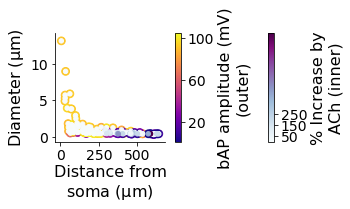

In [119]:
'''Spike train '''

stim = h.NetStim()
stim.interval = 20
stim.number = 12
stim.start = 50

'''Excitatory synaptic input'''

esyn = h.fac_exp2syn(sl_dendrites[0](0.5))
esyn.e=10
esyn.tau1=0.7
esyn.tau2=7

synw = 0.15

encstim = h.NetCon(stim,esyn)
encstim.weight[0]=synw

bAP_av = []

dist,diam = zip(*[(h.distance(0.5,sec=sec),sec.diam) for sec in h.allsec()])


for ach_imult in [6.0,1.0]: # For full and decrease feedforward inhibition
    isyns = []
    inclist = []
    for sec in [h.soma[0]]+sl_dendrites+sr_dendrites: # split up feedforward inhibition amongst various comparments

        isyn = h.afacdep_exp2syn(sec(0.5))
        isyn.e = -75
        isyn.tau1 = 4
        isyn.tau2 = 24

        isyns.append(isyn)

        incstim = h.NetCon(stim,isyn)
        incstim.delay=3
        if 'soma' in sec.name():
            incstim.weight[0] = encstim.weight[0]*ach_imult/2
        if 'dendrite' in sec.name():
            incstim.weight[0] = encstim.weight[0]*ach_imult/(2*len(sl_dendrites+sr_dendrites))
            
        inclist.append(incstim)
    
    
    '''Record'''
    vs_vec = h.Vector()
    t_vec = h.Vector()
    vs_vec.record(h.soma[0](0.5)._ref_v)
    
    vd_list = []
    
    for sec in h.allsec():
        vd_vec = h.Vector()
        vd_vec.record(sec(0.5)._ref_v)
        vd_list.append(vd_vec)
    
    t_vec.record(h._ref_t)

    h.tstop = stim.start*2 + stim.number*stim.interval
    h.run()
    
    vsom = np.array(vs_vec)
    vden = np.array(vd_list)
    
    vden_peaks_av_list = [average_vdenpeaks(vsom,vd)-vsom[0] for vd in vden]
    bAP_av.append(vden_peaks_av_list)

bAP_pre,bAP_cch = np.array(bAP_av)
bAP_pc_change = (bAP_cch/bAP_pre - 1)*100

fig = plt.figure(figsize=(4.5,2))

plt.scatter(dist,diam,c=bAP_pc_change,cmap=plt.cm.BuPu,s=20,zorder=2)#,color=plt.cm.BuPu(norm2(log_bAP_change)))
cb2 = plt.colorbar()
cb2.set_label('% Increase by\nACh (inner)',fontsize=16)
cb2.set_ticks([50,150,250])
cb2.ax.set_yticklabels(['50','150','250'],fontsize=14)

plt.scatter(dist,diam,c=bAP_pre,cmap=plt.cm.plasma,s=60,zorder=1)
cb1 = plt.colorbar(fraction=0.4)
cb1.set_label('bAP amplitude (mV)\n(outer)',fontsize=16)
cb1.set_ticks([20,60,100])
cb1.ax.set_yticklabels(['20','60','100'],fontsize=14)

plt.xlabel('Distance from\nsoma ($\mathrm{\mu m}$)',fontsize=16)
plt.ylabel('Diameter ($\mathrm{\mu m}$)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax = fig.axes[0]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#fig.savefig('./reworked_figs/ca3_backprop_ach_scatter.svg')

In [103]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

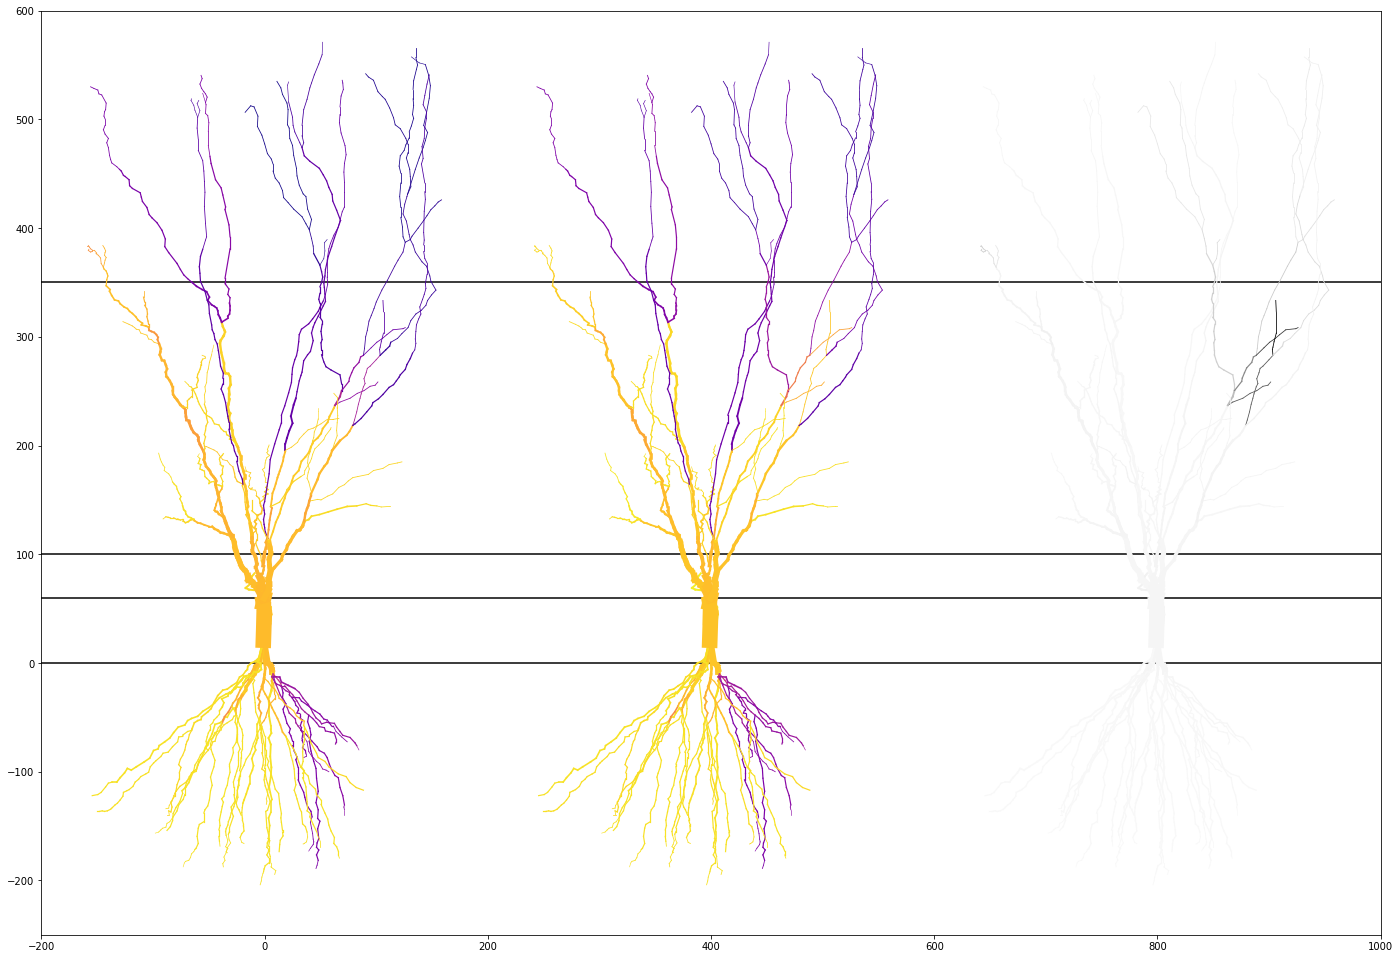

In [147]:
'''Spike train '''

stim = h.NetStim()
stim.interval = 20
stim.number = 12
stim.start = 50

'''Excitatory synaptic input'''

esyn = h.fac_exp2syn(sl_dendrites[1](0.5))
esyn.e=10
esyn.tau1=0.7
esyn.tau2=7

synw = 0.15

encstim = h.NetCon(stim,esyn)
encstim.weight[0]=synw

bAP_av = []

dist,diam = zip(*[(h.distance(0.5,sec=sec),sec.diam) for sec in h.allsec()])

for ach_imult in [6.0,1.0]: # For full and decrease feedforward inhibition
    isyns = []
    inclist = []
    for sec in [h.soma[0]]+sl_dendrites+sr_dendrites: # split up feedforward inhibition amongst various comparments

        isyn = h.afacdep_exp2syn(sec(0.5))
        isyn.e = -75
        isyn.tau1 = 4
        isyn.tau2 = 24

        isyns.append(isyn)

        incstim = h.NetCon(stim,isyn)
        incstim.delay=3
        if 'soma' in sec.name():
            incstim.weight[0] = encstim.weight[0]*ach_imult/2
        if 'dendrite' in sec.name():
            incstim.weight[0] = encstim.weight[0]*ach_imult/(2*len(sl_dendrites+sr_dendrites))
            
        inclist.append(incstim)
    
    
    '''Record'''
    vs_vec = h.Vector()
    t_vec = h.Vector()
    vs_vec.record(h.soma[0](0.5)._ref_v)
    
    vd_list = []
    
    for sec in h.allsec():
        vd_vec = h.Vector()
        vd_vec.record(sec(0.5)._ref_v)
        vd_list.append(vd_vec)
    
    t_vec.record(h._ref_t)

    h.tstop = stim.start*2 + stim.number*stim.interval
    h.run()
    
    vsom = np.array(vs_vec)
    vden = np.array(vd_list)
    
    vden_peaks_av_list = [average_vdenpeaks(vsom,vd)-vsom[0] for vd in vden]
    bAP_av.append(vden_peaks_av_list)

bAP_pre,bAP_cch = np.array(bAP_av)
bAP_dif = bAP_cch - bAP_pre

fig,ax = plt.subplots(figsize=(24,17))

cNorm1 = Normalize(vmin=0,vmax=110)
scalarMap1 = ScalarMappable(norm=cNorm1,cmap=plt.cm.plasma)

cNorm2 = Normalize(vmin=-5,vmax=80)
scalarMap2 = ScalarMappable(norm=cNorm2,cmap=plt.cm.Greys)

bAP_pre_iter = iter(bAP_pre)
bAP_cch_iter = iter(bAP_cch)
bAP_dif_iter = iter(bAP_dif)

for sec in h.allsec():
#     print sec.name()
    h.define_shape(sec)
    b1 = bAP_pre_iter.next()
    b2 = bAP_cch_iter.next()
    b3 = bAP_dif_iter.next()
    for i in range(int(h.n3d()))[1:]:
        x1,x2 = h.x3d(i-1),h.x3d(i)
        y1,y2 = h.y3d(i-1),h.y3d(i)
        w = h.diam3d(i)
        plt.plot([x1,x2],[y1,y2],'-',lw=w*2,color=scalarMap1.to_rgba(b1))
        plt.plot([x1+400,x2+400],[y1,y2],'-',lw=w*2,color=scalarMap1.to_rgba(b2))
        plt.plot([x1+800,x2+800],[y1,y2],'-',lw=w*2,color=scalarMap2.to_rgba(b3))

plt.ylim(-250,600)
plt.xlim(-200,1000)

plt.hlines(y=[0,60,100,350],xmin=-200,xmax=1000)

(array([ 116.,    7.,    6.,    1.,    0.,    1.,    0.,    2.,    1.,    1.]),
 array([ -0.30043845,   7.58964673,  15.4797319 ,  23.36981708,
         31.25990226,  39.14998744,  47.04007262,  54.93015779,
         62.82024297,  70.71032815,  78.60041333]),
 <a list of 10 Patch objects>)

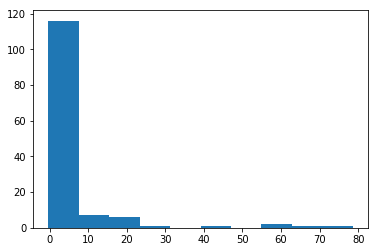

In [139]:
plt.hist(bAP_dif)

In [136]:
bAP_dif

array([[  2.49247956e+00,   4.93151858e+00,   2.30040740e+00,
         -1.34772375e-01,   1.95145364e+00,   2.00186594e-01,
         -2.92181994e-01,  -2.06149777e-01,   1.08730119e+00,
          1.04813972e+00,   2.16796804e-01,   9.89869304e-01,
          3.09981663e-01,   8.57666607e-01,   8.22751002e-01,
          6.83205733e-01,   5.78738222e-01,   5.07093633e-01,
          7.02069440e-01,   1.96434701e+00,   5.69591273e-01,
          3.23354400e-01,   3.92968488e-01,   2.27232842e+00,
          1.17052656e+00,   5.35592057e-01,  -2.15998740e-01,
         -2.15487112e-01,   2.80718281e-01,  -2.73207792e-01,
         -2.09355861e-01,   1.72811468e-01,  -2.27680734e-01,
         -3.01894238e-01,   1.55440449e+00,   8.32094729e-01,
         -2.30160361e-01,  -2.44568513e-01,   7.24394804e-01,
         -1.83449718e-01,  -2.57438473e-01,   2.29157704e+00,
          1.86349805e+00,  -8.41616494e-02,  -1.29728332e-01,
          7.42805624e-01,  -2.57787834e-02,  -1.87559452e-01,
        

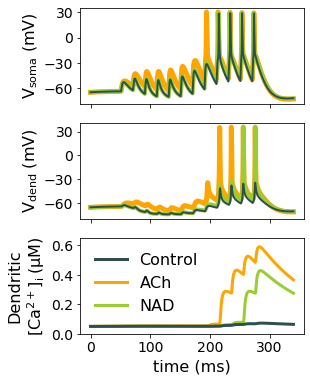

In [54]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(4,6),sharex=True,sharey='row',frameon=False)

t_ctr, vs_ctr, vd_ctr, ca_ctr = ach_result[0]
t_ach, vs_ach, vd_ach, ca_ach = ach_result[1]
t_nad, vs_nad, vd_nad, ca_nad = nad_result[1]

plt.sca(axs[0])
plt.plot(t_ctr, vs_ctr, lw=2, zorder=-1, color='darkslategrey')
plt.plot(t_ach, vs_ach, lw=5, zorder=-3, color='orange')
plt.plot(t_nad, vs_nad, lw=4, zorder=-2, color='yellowgreen')

plt.sca(axs[1])
plt.plot(t_ctr, vd_ctr, lw=2, zorder=-1, color='darkslategrey')
plt.plot(t_ach, vd_ach, lw=5, zorder=-3, color='orange')
plt.plot(t_nad, vd_nad, lw=4, zorder=-2, color='yellowgreen')

plt.sca(axs[2])
plt.plot(t_ctr, ca_ctr*1000, lw=3, zorder=-1, color='darkslategrey', label='Control')
plt.plot(t_ach, ca_ach*1000, lw=3, zorder=-3, color='orange', label='ACh')
plt.plot(t_nad, ca_nad*1000, lw=3, zorder=-2, color='yellowgreen', label='NAD')
plt.legend(fontsize=16,frameon=False)


plt.sca(axs[0])
plt.ylabel('$\mathrm{V_{soma}}$ (mV)',fontsize=16)
plt.yticks([-60,-30,0,30],fontsize=14)

plt.sca(axs[1])
plt.ylabel('$\mathrm{V_{dend}}$ (mV)',fontsize=16)
plt.yticks([-60,-30,0,30],fontsize=14)

plt.sca(axs[2])
plt.ylabel('Dendritic\n$\mathrm{[Ca^{2+}]_i\:(\mu M)}$',fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel('time (ms)',fontsize=16)
plt.xticks(fontsize=14)
plt.ylim(0, 0.65)

fig.savefig('./reworked_figs/ca3_backprop_all_example.svg')